In [45]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append("../")

from sprintdl.main import *
from sprintdl.models.efficientnet import *
from sprintdl.models.xresnet import *

device = torch.device('cuda',0)
from torch.nn import init
import torch
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
AUDIO_EXTS = {str.lower(k) for k,v in mimetypes.types_map.items() if v.startswith('audio/')}

In [47]:
class AudioList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = AUDIO_EXTS
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): 
        sig, sr = torchaudio.load(fn)
        assert sig.size(0) == 1, "Non-mono audio detected, mono only supported for now."
        return (sig, sr)

In [48]:
def show_audio(ad):
    sig,sr=ad
    display(Audio(data=sig, rate=sr))

In [49]:
def show_audio_in_out(orig, trans):
    ossig, osr = orig
    tsig, tsr = trans
    print("↓ Original ↓")
    show_audio(orig)
    print("↓ Transformed ↓")
    show_audio(trans)
    if orig is not None: plt.plot(osig[0], 'm', label="Orig.")
    if trans is not None: plt.plot(tsig[0], 'c', alpha=0.5, label="Transf.")
    plt.legend()
    plt.show()

In [50]:
class AudioCuda(Transform):
    _order=10
    def __call__(self, ad):
        sig,sr = ad
        return (sig.cuda(), sr)

In [52]:
class PadOrTrim(Transform):
    _order = 11
    def __init__(self, msecs): self.msecs = msecs
    def __call__(self, ad):
        sig,sr = ad
        mx = sr//1000 * self.msecs
        return (transforms.PadOrTrim(mx)(sig), sr)

In [53]:
class SignalShift(Transform):
    _order=20
    def __init__(self, max_shift_pct=.6): self.max_shift_pct = max_shift_pct
    def __call__(self, ad):
        sig,sr = ad
        roll_by = int(random.random()*self.max_shift_pct*len(sig[0]))
        return (sig.roll(roll_by), sr)

In [92]:
class Spectrogrammer(Transform):
    _order=90
    def __init__(self, to_mel=True, to_db=True, n_fft=400, ws=None, hop=None, 
                 f_min=0.0, f_max=None, pad=0, n_mels=128, top_db=None, normalize=False):
        self.to_mel, self.to_db, self.n_fft, self.ws, self.hop, self.f_min, self.f_max, \
        self.pad, self.n_mels, self.top_db, self.normalize = to_mel, to_db, n_fft, \
        ws, hop, f_min, f_max, pad, n_mels, top_db, normalize

    def __call__(self, ad):
        ad = ad
        sig,sr = ad
        if self.to_mel:
            spec = transforms.MelSpectrogram(sr, self.n_fft, self.ws, self.hop, self.f_min, 
                                             self.f_max, self.pad, self.n_mels)(sig)
        else: 
            spec = transforms.Spectrogram(self.n_fft, self.ws, self.hop, self.pad, 
                                          normalize=self.normalize)(sig)
        if self.to_db:
            spec = transforms.SpectrogramToDB(top_db=self.top_db)(spec)
        spec = spec.permute(0,2,1) # reshape so it looks good to humans
        return spec

In [93]:
def show_spectro(img, ax=None, figsize=(6,6), with_shape=True):
    if hasattr(img,"device") & str(img.device).startswith("cuda"): img = img.cpu()
    if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img if (img.shape[0]==3) else img.squeeze(0))
    if with_shape: display(f'Tensor shape={img.shape}')

In [94]:
class SpecAugment(Transform):
    _order=99
    def __init__(self, max_mask_pct=0.2, freq_masks=1, time_masks=1, replace_with_zero=False):
        self.max_mask_pct, self.freq_masks, self.time_masks, self.replace_with_zero = \
        max_mask_pct, freq_masks, time_masks, replace_with_zero
        if not 0 <= self.max_mask_pct <= 1.0: 
            raise ValueError( f"max_mask_pct must be between 0.0 and 1.0, but it's {self.max_mask_pct}")

    def __call__(self, spec):
        _, n_mels, n_steps = spec.shape
        F = math.ceil(n_mels * self.max_mask_pct) # rounding up in case of small %
        T = math.ceil(n_steps * self.max_mask_pct)
        fill = 0 if self.replace_with_zero else spec.mean()
        for i in range(0, self.freq_masks):
            f = random.randint(0, F)
            f0 = random.randint(0, n_mels-f)
            spec[0][f0:f0+f] = fill
        for i in range(0, self.time_masks):
            t = random.randint(0, T)
            t0 = random.randint(0, n_steps-t)
            spec[0][:,t0:t0+t] = fill
        return spec

In [95]:
def show_batch_audio(x, c=4, r=None, figsize=None, shower=show_image):
    n = len(x)
    if r is None: r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3,r*3)
    fig,axes = plt.subplots(r,c, figsize=figsize)
    for xi,ax in zip(x,axes.flat): shower(xi, ax)

# Define required

In [96]:
fpath = Path("/media/hdd/Datasets/STAEDS/")

In [97]:
pad_3sec = PadOrTrim(3000)
shifter = SignalShift()
speccer = Spectrogrammer(n_fft=1024, n_mels=64, top_db=80)
masker = SpecAugment(freq_masks=2, time_masks=2, max_mask_pct=0.1)

tfms = [AudioCuda(), shifter, speccer, masker]
bs = 256

In [98]:
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

cbfs = [
    partial(AvgStatsCallback,accuracy),
    partial(ParamScheduler, 'lr', sched_lr),
    partial(ParamScheduler, 'mom', sched_mom),
        partial(BatchTransformXCallback, norm_imagenette),
    ProgressCallback,
    Recorder,]
#        partial(CudaCallback, device)]

loss_func=LabelSmoothingCrossEntropy()
lr = .001
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [99]:
al = AudioList.from_files(fpath, tfms=tfms)
sd = SplitData.split_by_func(al, partial(random_splitter, p_valid=0.2))
label_pat = r'/([mf]\d+)_'

ll = label_by_func(sd, partial(re_labeler, pat=label_pat), proc_y=CategoryProcessor())

In [100]:
c_in = ll.train[0][0].shape[0]
c_out = len(uniqueify(ll.train.y))
data = ll.to_databunch(bs, c_in=3, c_out=5)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [44]:
show_spec_batch = partial(show_batch_audio, c=4, r=2, figsize=None, 
                          shower=partial(show_spectro, with_shape=False))

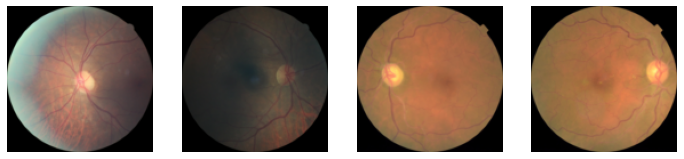

In [22]:
x,y = next(iter(data.train_dl))
show_spec_batch(x)

In [68]:
arch = partial(xresnet34, c_out =5)()

In [69]:
learn = Learner(arch, data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [70]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.056832,0.722090,1.014824,0.731083,08:36
